# INFO 2950 Project Phase 5

#### Talia Boehm, Lucy Barsanti, Emma Shen, Maddi Klancher


Link to dataset: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Introduction #

## **Research Question:** 
* **Main Question**: How did the COVID-19 pandemic affect airline delays?

* **Supporting Questions**: What is the relationship between the COVID-19 rate and airline delays in the United States between January 2020 - July 2022? Does the relationship differ between states? By airline?

With roughly 100,000 flights taking off around the world each day, there is an abundance of flight data that reflects global travel and consumer trends. The rise of the COVID-19 pandemic in early 2020 shook a myriad of industries across the United States. As the world went into isolation, travel and tourism significantly fell globally. The airline industry was one of the most impacted industries over the course of the pandemic and it still has years ahead until full recovery. Understanding this relationship between COVID-19 and flight data can help us identify strategies for airline companies to recover post COVID-19 and increase efficiency in their operations. 

Flight data has a seasonality component as travel typically tends to increase in warmer months and popular holiday seasons. Destinations known for tourism experience this fluctuation to a greater degree. This seasonality component makes flight data trends more predictable from a data science perspective. However, the COVID-19 pandemic was anything but predictable. 

Our research looks into how the COVID-19 pandemic affected airline delays across the United States. We have explored how this relationship varies across different states and airlines. To do so, we analyzed a public dataset on flight delays across the U.S from January 2017 to July 2022. COVID-19 cases started rising in the United States in March 2020. Therefore, our flight delay dataset reflects airline patterns before and after the pandemic, allowing us to draw comparisons over time. 

There were also clear geographical differences in the number of COVID-19 cases across the U.S. To account for these differences, we chose a public dataset on COVID-19 cases organized by states that aligns with the airport locations in our flight delay dataset. 

In our research, we investigate the different reasons that cause flight delays, considering both their frequency and measure of time. We also explore differences across airlines by controlling the date and airport location. 
We learned that the states with higher rates of COVID-19 cases resulted in worse flight delay predictions. Therefore, our models proved to be more representative of the data for states with the least amount of COVID-19 cases. These findings align with our initial ideas surrounding the unpredictability of the pandemic.


# Data Description

## Flight delay data from January 2017 - July 2022:

* This dataset contains information on flights in the United States from January 2017 to July 2022. The data contains attributes including the flight date, flight number, origin airport, destination airport, departure time, arrival time, and the reason for any delays. There are 7 reasons for flight delays outlined by the dataset: air carrier delay, weather delay, national aviation system delay, security delay, aircraft arriving late, canceled, and diverted. 

* Raw data can be found [here](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp) 
* Link to our [Google Drive](https://drive.google.com/file/d/1Ci4XzBpg3BF-_zx70sBTN1uVkaERmTgl/view?usp=sharing)

* **Observations**: Each observation in the dataset includes the number of occurrences of each cause of delay for one airline at one airport for one month. For example, one row in the dataset represents the flight delay statistics for American Airlines at Nashville International Airport for the month of July 2022. 

* **Attributes**: The attributes of this dataset are as follows:

**year:** Year data collected\
**month:** Numeric representation of the month\
**carrier:** Airline carrier number\
**carrier_name:** Airline carrer\
**airport:** Official airport code\
**airport_name:** Full airport name\
**arr_flights:** Number of flights arriving at airport\
**arr_del15:** Number of flights more than 15 minutes late\
**carrier_ct:** Number of flights delayed due to air carrier. (e.g. no crew)\
**weather_ct:** Number of flights due to weather\
**nas_ct:** Number of flights delayed due to National Aviation System\
**security_ct:** Number of flights canceled due to a security breach\
**late_aircraft_ct:** Number of flights delayed as a result of another flight on the same aircraft delayed\
**arr_cancelled:** Total number of canceled flights\
**arr_diverted:** Total number of diverted flights\
**arr_delay:** Total number of minutes of delay for arriving flights\
**carrier_delay:** Total number of minutes of delay due to carrier delays\
**weather_delay:** Total number of minutes of delay due to weather delays\
**nas_delay:** Total number of minutes of delay due to National Aviation System delays\
**security_delay:** Total number of minutes of delay due to security delays\
**late_aircraft_delay:** Total time (minutes) of delay as a result of a previous flight on the same airplane being late

* The U.S. Department of Transportation (DOT) created and funded the monthly Air Travel Consumer Report to provide information to the public about the quality of air travel. In response, the Bureau of Transportation Statistics (BTS) began collecting details on the causes of flight delays in June 2003. The air travel data found on the BTS website is publicly available and required by the U.S. Congress.

* Operating carriers that have a 0.5 percent of total domestic scheduled-service passenger revenue are required to report on-time data and the causes of delay. Our data comes from these 17 operating carriers reporting non-stop scheduled-service flights between points within the United States and including territories. The DOT’s framework determined the reporting categories to ensure the public would have clear information about the nature and sources of airline delays and cancellations. The Bureau of Transportation Statistics conducted a pilot program to test the monthly reporting of causation and then implemented this framework in 2001. All people involved were aware of the data collection and the processes outlined byt the DOT. They expected the information to be used by the BTS and made public.

* The DOT defines a “delayed” flight if it operated more than 15 minutes later than the scheduled arrival time. As a result, the data on delayed flights abides by this definition. Moreover, the nature of airline self reporting may have influenced what data was observed and recorded and what was not.

* The health professionals conducting data collection and administering and recieving the COVID-19 tests were aware of this data collection. However, it is likely that some civilians are not aware of this dataset and its usages.

* We downloaded the data from the BTS website as a CSV file.

## COVID-19 cases and deaths by state over time from January 22, 2020 - October 20, 2022:

* The raw data can be found [here](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data)

* Link to our [Google Drive](https://drive.google.com/file/d/1i3fQ9wMkgdViOwuJO_EKLR2p1Hd_UCyF/view?usp=sharing)

* This dataset contains archived aggregate daily counts of COVID-19 cases and death by state. 

* **Observations**: Each observation contains archived aggregate daily counts of COVID-19 cases and death for each state in the United States. For example, we can see one row that contains data from 10/18/22 for the state of New York with 3,275,131 total cases, 1,660 new cases, 29,356 total deaths, 32 new deaths, and 0 new probable deaths.

* **Attributes**: The attributes of this dataset are as follows:

**submission_date:** date of counts\
**state:** jurisdiction\
**tot_cases:** total number of cases\
**conf_cases:** total confirmed cases\
**prob_cases:** total probable cases\
**new_case:** number of new cases\
**pnew_case:** number of new probable cases\
**tot_death:** total number of deaths\
**conf_death:** total confirmed deaths\
**prob_death:** total probable deaths\
**new_death:** number of new deaths\
**pnew_death:** number of new probable deaths\
**created_at:** date and time record was created\
**consent_cases:** if agree, then confirmed and probable cases are included\
**consent_deaths:** if agree, then confirmed and probable deaths are included\
**year:** year or counts\
**month:** month of counts


* The Centers for Disease Control and Prevention (CDC) made the United States COVID-19 Cases and Deaths by State over Time dataset to track the spread of COVID-19 in the United States. The United States government funded this dataset. 

* We are using the data to compare flight delay information with COVID-19 cases on a monthly basis based on state to determine if there is any relationship between the two datasets.

* The CDC retrieves aggregate case and death data from jurisdictional and state partners. However, counting the exact number of COVID-19 cases is not possible due to a variety of reasons. For instance, people do not always report their illnesses, symptoms might not appear immediately, and there may be delays in testing. Moreover, there are sometimes false test results. Additionally, each state may have different testing and reporting protocols, population sentiment toward COVID-19, and levels of testing efficiency.

* We downloaded the data from the CDC’s website as a CSV file.

# Preregistration Statement #

- We will compare how the relationship between the COVID-19 rate and the number of different types of airline delays in the U.S between January 2022-July 2022 vary across different states.
- Given the known and publicized decrese in airline staff and increase in airline delayes during times of high COVID-19 rates, we hypothesize that there will be a strong positive correlation between covid cases and carrier_ct.
- We will compare how the relationship between the COVID-19 rate and the number of airline delays in the U.S between January 2022-July 2022 vary across different airlines.
- Given the highly disruptive nature of the pandemic to the travel industry, we hypothesize that we will find a strong positive correlation between COVID-19 cases and airline delays in the U.S.

# Data Analysis 

## 1. Flight Delays Dataset
_Note: For a detailed description of this dataset, please see the section "Data Description" above._

The following cells show a preview of the original Flight Delay dataframe.
•	This dataframe is stored in the variable df_delays


In [331]:
df_delays = pd.read_csv('Airline_Delay_Cause.csv')
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,0.0,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0


### Inserting new column "state"
By parsing each value in the column __airport_name__, we extracted the 2-character state abbrevaition for each row of data and created a new column __state__.

_Rationale for change:_ As you will see in the next section, the COVID dataset has a column- state- containing the state pertinent to each row of data. To combine the COVID and Flight Delay for specific stats, we needed to insert the column state into df_delays. This addition allows us to join the 2 datasets on the __state__ column.

In the preview of df_delays below, you can see the new column titled __state__


In [332]:
airports= df_delays['airport_name']
state = []
for x in airports:
    idx = x.rindex(":")
    start = idx - 2
    state_x = x[start: idx]
    state.append(state_x)

df_delays['state'] = state
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA


## 2. COVID Data by State

_Note: For a detailed description of this dataset, please see the section "Data Description" above._

The following cells show a preview of the dataframe stored in the variable __df_covid__. The dataset contains information about COVID cases over time in each US State.

In [333]:
df_covid = pd.read_csv('Covid-by-State.csv')
df_covid['submission_date']= pd.to_datetime(df_covid['submission_date'])
df_covid['year'] = pd.DatetimeIndex(df_covid['submission_date']).year
df_covid['month'] = pd.DatetimeIndex(df_covid['submission_date']).month
df_covid.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,year,month
0,2021-03-11,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN,2021,3
1,2021-12-01,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree,2021,12
2,2022-01-02,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN,2022,1
3,2021-11-22,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree,2021,11
4,2022-05-30,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN,2022,5


### Cleaning the COVID Dataset

Steps taken to clean __df_covid__:
- Summing COVID data for each MONTH
- Grouping and ordering by: state, month, and year
    - The flight delay dataset and the COVID dataset have these 3 columns in common, so this is how we will group and order our data when combining __df_covid__ and __df_delays__
    - This ordering is also logical because the year/ month increases as you travel down the rows in the dataset, and the states are ordered alphabetically (A-Z)


In [334]:

# %sql df_covid_cleaned << SELECT year, month, state, SUM(tot_cases) AS tot_case, SUM(new_case) AS new_case FROM df_covid GROUP BY state, month, year ORDER BY year, month, state ASC

# df_covid_cleaned

%sql df_covid_cleaned << SELECT year, month, state, MAX(tot_cases) AS tot_case, MAX(new_case) AS new_case FROM df_covid GROUP BY state, month, year ORDER BY year, month, state ASC

df_covid_cleaned


Returning data to local variable df_covid_cleaned


,year,month,state,tot_case,new_case
0,2020,1,AK,0,0
1,2020,1,AL,0,0
2,2020,1,AR,0,0
3,2020,1,AS,0,0
4,2020,1,AZ,1,1
...,...,...,...,...,...
2035,2022,10,VT,133845,217
2036,2022,10,WA,1828918,1275
2037,2022,10,WI,1884206,2262
2038,2022,10,WV,605012,795


In [335]:
## Lucy
dates = df_covid_cleaned[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
df_covid_cleaned['year_month'] = month_date

df_covid_cleaned.head()


,year,month,state,tot_case,new_case,year_month
0,2020,1,AK,0,0,2020.083333
1,2020,1,AL,0,0,2020.083333
2,2020,1,AR,0,0,2020.083333
3,2020,1,AS,0,0,2020.083333
4,2020,1,AZ,1,1,2020.083333


## Dataset Summary Statistics

To gain more insight into our flight delay dataset, we calculated summary statistics.

In [336]:
df_delays.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,101315.000000,101315.000000,101157.000000,100960.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000
mean,2019.516261,6.279633,336.033413,58.073217,18.457503,2.047227,17.234516,0.153487,20.067422,7.969137,0.773362,3817.083069,1319.266744,212.609785,838.294967,7.370395,1439.534031
std,1.558253,3.438409,942.283273,163.327000,47.042014,6.878678,58.427910,0.734138,63.043181,50.943481,3.395803,11715.243158,3941.461650,810.274436,3390.448796,44.296998,4636.488256
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,42.000000,5.000000,1.920000,0.000000,0.940000,0.000000,1.000000,0.000000,0.000000,265.000000,86.000000,0.000000,24.000000,0.000000,42.000000
50%,2020.000000,6.000000,90.000000,14.000000,5.280000,0.240000,3.200000,0.000000,3.960000,1.000000,0.000000,865.000000,316.000000,12.000000,120.000000,0.000000,253.000000
75%,2021.000000,9.000000,227.000000,40.000000,14.610000,1.660000,9.850000,0.000000,12.640000,4.000000,1.000000,2520.000000,990.000000,132.000000,401.000000,0.000000,916.000000
max,2022.000000,12.000000,21931.000000,4176.000000,1147.000000,226.000000,1884.420000,58.690000,1531.810000,4951.000000,154.000000,429194.000000,151581.000000,28294.000000,112018.000000,3760.000000,147167.000000


### Insights 

- The summary statistics provide the most insight into the attributes describing kinds of flight delay 

- Comparing the means of carrier_ct, weather_ct, nas_ct, security_c, and late_aircraft_ct provides insight into which kinds of delays are most common. 

- This summary suggests that most delays are caused by the carrier and the National Aviation System.

- Using this insight, we could look further into how these two delays were impacted by COVID-19.



In [337]:
df_delays.cov()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,2.428154,-0.832977,-6.718626e+01,-1.325660e+01,0.230191,-0.066425,-7.168262,0.047085,-6.318323,1.658279,-0.154792,-7.818894e+02,2.268752e+00,-7.075067e+00,-3.897434e+02,1.722785,-3.890604e+02
month,-0.832977,11.822658,1.065531e+01,4.102916e-01,0.686685,-0.315940,-0.654819,0.039809,0.879325,-10.906314,-0.024509,-1.297061e+02,-2.307489e+01,-4.898322e+01,-7.077646e+01,1.744172,1.137298e+01
arr_flights,-67.186256,10.655307,8.878978e+05,1.404775e+05,39367.088162,4679.338144,44476.155668,313.148556,51405.029711,18933.043955,2054.580549,9.641598e+06,3.245608e+06,4.965375e+05,2.207962e+06,15484.212247,3.675999e+06
arr_del15,-13.256602,0.410292,1.404775e+05,2.667571e+04,7180.440447,853.234061,8677.801335,57.662711,9906.566675,2789.656871,388.144232,1.854742e+06,5.810391e+05,9.119166e+04,4.577775e+05,2807.667120,7.219255e+05
carrier_ct,0.230191,0.686685,3.936709e+04,7.180440e+03,2212.951086,239.503881,2034.515759,17.430875,2664.141276,781.290124,102.352660,4.933739e+05,1.740625e+05,2.504507e+04,1.025393e+05,858.822499,1.908681e+05
weather_ct,-0.066425,-0.315940,4.679338e+03,8.532341e+02,239.503881,47.316213,266.072638,1.718300,297.192779,91.267118,14.745818,6.424280e+04,2.139860e+04,5.146355e+03,1.452679e+04,88.746870,2.308229e+04
nas_ct,-7.168262,-0.654819,4.447616e+04,8.677801e+03,2034.515759,266.072638,3413.820663,16.276992,2932.163117,891.661189,130.109759,6.116023e+05,1.724931e+05,2.913312e+04,1.871459e+05,793.778819,2.220363e+05
security_ct,0.047085,0.039809,3.131486e+02,5.766271e+01,17.430875,1.718300,16.276992,0.538958,21.602632,6.169991,0.786131,3.710536e+03,1.275302e+03,1.700977e+02,7.522819e+02,26.159352,1.486691e+03
late_aircraft_ct,-6.318323,0.879325,5.140503e+04,9.906567e+03,2664.141276,297.192779,2932.163117,21.602632,3974.442679,1013.585544,139.470473,6.786315e+05,2.108271e+05,3.154346e+04,1.520165e+05,1035.524721,2.832089e+05
arr_cancelled,1.658279,-10.906314,1.893304e+04,2.789657e+03,781.290124,91.267118,891.661189,6.169991,1013.585544,2595.238262,48.255570,2.043152e+05,6.799876e+04,1.086049e+04,4.927227e+04,286.004521,7.589764e+04


### Insights 

- The covariance between variables reflects the relationships between our dataset attributes.
- To gain more indepth insight into these relationships, we will look into a correlation matrix. The correlation is normalized, creating standardized values to access tbe strength of the linear relationships between the attributes.


In [10]:
df_delays.corr()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,-0.155467,-0.045741,-0.052033,0.003139,-0.006195,-0.078704,0.041144,-0.064294,0.020882,-0.029242,-0.042815,0.000369,-0.005601,-0.073744,0.024950,-0.053831
month,-0.155467,1.000000,0.003289,0.000730,0.004245,-0.013358,-0.003259,0.015770,0.004057,-0.062263,-0.002099,-0.003220,-0.001703,-0.017581,-0.006071,0.011451,0.000713
arr_flights,-0.045741,0.003289,1.000000,0.912000,0.888108,0.721935,0.807840,0.452680,0.865338,0.394412,0.642095,0.873406,0.873891,0.650337,0.691119,0.370965,0.841404
arr_del15,-0.052033,0.000730,0.912000,1.000000,0.933790,0.758786,0.908542,0.480457,0.961273,0.334992,0.699186,0.968492,0.901808,0.688448,0.825927,0.387705,0.952495
carrier_ct,0.003139,0.004245,0.888108,0.933790,1.000000,0.740153,0.740210,0.504726,0.898324,0.326015,0.640724,0.895239,0.938776,0.657059,0.642906,0.412139,0.875101
weather_ct,-0.006195,-0.013358,0.721935,0.758786,0.740153,1.000000,0.662026,0.340264,0.685323,0.260448,0.631279,0.797202,0.789265,0.923342,0.622884,0.291255,0.723744
nas_ct,-0.078704,-0.003259,0.807840,0.908542,0.740210,0.662026,1.000000,0.379469,0.796030,0.299565,0.655763,0.893506,0.749021,0.615367,0.944719,0.306694,0.819624
security_ct,0.041144,0.015770,0.452680,0.480457,0.504726,0.340264,0.379469,1.000000,0.466757,0.164975,0.315337,0.431427,0.440735,0.285949,0.302236,0.804406,0.436771
late_aircraft_ct,-0.064294,0.004057,0.865338,0.961273,0.898324,0.685323,0.796030,0.466757,1.000000,0.315598,0.651481,0.918850,0.848459,0.617503,0.711206,0.370807,0.968901
arr_cancelled,0.020882,-0.062263,0.394412,0.334992,0.326015,0.260448,0.299565,0.164975,0.315598,1.000000,0.278944,0.342342,0.338653,0.263105,0.285270,0.126739,0.321329


### Insights 

- The correlation matrix provides insight into patterns and relationships between our dataset's attributes
- We focus on the metrics in the arr_del15 column to explore which factors may influence airline delays the most.
- We see that the arr_del15 variable has close to zero linear correlation with the month, suggesting delays do not have seasonal trends. Therefore, there are extraneous factors that we must explore.
- This matrix suggests that delays are most influenced by the air carrier (e.g no crew), the National Aviation System,and late aircraft arrivals. We identified these variables by their high and positive correlation values with arr_del15.


## Adding Columns: 

We add two columns (percent_delayed and	percent_cancelled) to show patterns in delays as the number of flights arriving at each airport significantly fluctuates each month over the COVID-19 pandemic.

In [338]:
df_delays["percent_delayed"] = df_delays["arr_del15"]/df_delays["arr_flights"]
df_delays["percent_cancelled"] = df_delays["arr_cancelled"]/df_delays["arr_flights"]
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA,0.060606,0.000000
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA,0.320513,0.000000
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA,0.153226,0.040323
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA,0.149254,0.000000
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA,0.172414,0.005747


### Merging Datasets

In [339]:
%sql df_covid_flight << SELECT df_delays.*, df_covid_cleaned.tot_case, df_covid_cleaned.new_case, df_covid_cleaned.year_month FROM df_delays INNER JOIN df_covid_cleaned ON df_delays.month = df_covid_cleaned.month AND df_delays.year = df_covid_cleaned.year AND df_delays.State = df_covid_cleaned.state

df_covid_flight

Returning data to local variable df_covid_flight


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled,tot_case,new_case,year_month
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,23.0,8.0,0.0,0.0,PA,0.060606,0.000000,3090149,6991,2022.583333
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,52.0,224.0,0.0,501.0,GA,0.320513,0.000000,2750915,29524,2022.583333
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,35.0,511.0,0.0,589.0,MA,0.153226,0.040323,1966919,11525,2022.583333
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,82.0,93.0,25.0,354.0,LA,0.149254,0.000000,1377666,4370,2022.583333
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,310.0,139.0,0.0,327.0,GA,0.172414,0.005747,2750915,29524,2022.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50634,2020,1,YV,Mesa Airlines Inc.,RIC,"Richmond, VA: Richmond International",5.0,1.0,1.00,0.00,...,0.0,0.0,0.0,0.0,VA,0.200000,0.000000,0,0,2020.083333
50635,2020,1,YV,Mesa Airlines Inc.,ROA,"Roanoke, VA: Roanoke Blacksburg Regional Woodr...",1.0,1.0,0.00,0.00,...,0.0,0.0,0.0,61.0,VA,1.000000,0.000000,0,0,2020.083333
50636,2020,1,YX,Republic Airline,BTV,"Burlington, VT: Burlington International",173.0,22.0,4.36,0.00,...,0.0,207.0,0.0,520.0,VT,0.127168,0.005780,0,0,2020.083333
50637,2020,1,YX,Republic Airline,ORF,"Norfolk, VA: Norfolk International",93.0,13.0,3.68,0.00,...,0.0,79.0,0.0,337.0,VA,0.139785,0.010753,0,0,2020.083333


## Visualization 1: New COVID Cases by State

This visualaization uses a Log Scale to show how COVID cases increased in each state over time. 

### Insights

- COVID cases skyrocketed at the beginning months of 2020
- COVID cases have remained high from 5/2020 to 7/2022 despite fluctuations.
- Trend lines for each state are parallel to one another, suggesting that the rate of new infections has changed at similar rates across state lines. 

In [341]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

average_covid_df = df_covid_cleaned[['state', 'tot_case']].groupby(['state']).mean(['tot_case']).sort_values(by='tot_case', ascending=False)
average_covid_df = average_covid_df.reset_index()

most_covid = average_covid_df['state'].head(17).tolist()
print(most_covid)

mid_covid = average_covid_df['state'].head(33).tail(16).tolist()
print(mid_covid)

least_covid = average_covid_df['state'].tail(17).tolist()
print(least_covid)

# if state is contained in most_covid, add a column for high medium and low
df_hml = df_covid_cleaned
print(df_hml.head())


hml = []

for state in df_hml['state']:
    if state in most_covid:
        hml.append('high')
    elif state in mid_covid:
        hml.append('mid')
    else:
        hml.append('low')
    
df_hml['hml'] = hml


['CA', 'TX', 'FL', 'IL', 'PA', 'NY', 'OH', 'GA', 'NC', 'MI', 'NYC', 'NJ', 'TN', 'AZ', 'IN', 'MA', 'VA']
['WI', 'SC', 'MO', 'MN', 'CO', 'WA', 'AL', 'KY', 'LA', 'MD', 'OK', 'UT', 'AR', 'MS', 'IA', 'CT']
['MT', 'DE', 'SD', 'ND', 'AK', 'ME', 'HI', 'WY', 'DC', 'VT', 'GU', 'VI', 'MP', 'AS', 'FSM', 'PW', 'RMI']
   year  month state  tot_case  new_case   year_month   hml
0  2020      1    AK         0         0  2020.083333   low
1  2020      1    AL         0         0  2020.083333   mid
2  2020      1    AR         0         0  2020.083333   mid
3  2020      1    AS         0         0  2020.083333   low
4  2020      1    AZ         1         1  2020.083333  high


In [342]:
%sql high_states << SELECT SUM(new_case) as new_case, year_month FROM df_hml WHERE hml = 'high' GROUP BY year_month
%sql mid_states << SELECT SUM(new_case) as new_case, year_month FROM df_hml WHERE hml = 'mid' GROUP BY year_month
%sql low_states << SELECT SUM(new_case) as new_case, year_month FROM df_hml WHERE hml = 'low' GROUP BY year_month

Returning data to local variable high_states
Returning data to local variable mid_states
Returning data to local variable low_states


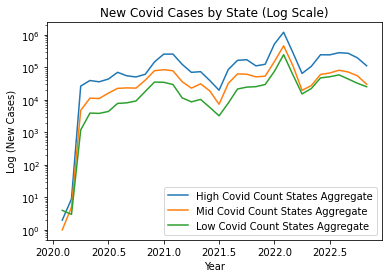

In [343]:
plt.yscale('log')
plt.title("New Covid Cases by State (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Log (New Cases)")


x_high = high_states['year_month']
y_high = high_states['new_case']
    
plt.plot(x_high, y_high, label = "High Covid Count States Aggregate")

x_mid = mid_states['year_month']
y_mid = mid_states['new_case']
    
plt.plot(x_mid, y_mid, label = "Mid Covid Count States Aggregate")

x_low = low_states['year_month']
y_low = low_states['new_case']
    
plt.plot(x_low, y_low, label = "Low Covid Count States Aggregate")

plt.legend()



In [344]:
%sql Endeavor_ABE_22_df << SELECT * FROM df_delays WHERE carrier = '9E' AND airport = 'ABE' AND year = 2022
Endeavor_ABE_22_df.head()

Returning data to local variable Endeavor_ABE_22_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA,0.060606,0.000000
1,2022,6,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",133.0,14.0,9.28,0.03,...,0.0,853.0,625.0,2.0,56.0,0.0,170.0,PA,0.105263,0.022556
2,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,0.0,255.0,222.0,0.0,4.0,0.0,29.0,PA,0.051471,0.000000
3,2022,4,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",132.0,6.0,2.00,0.00,...,0.0,170.0,58.0,0.0,101.0,0.0,11.0,PA,0.045455,0.000000
4,2022,3,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",135.0,12.0,4.21,1.93,...,1.0,513.0,124.0,180.0,107.0,25.0,77.0,PA,0.088889,0.000000


## Visualization 2: Endeavor Air Inc. Delays at ABE from Jan-Jul 2022

This is a lineplot showing the number of Endeavor Airlines flight delays at airport ABE (Allentown/Bethlehem/ Easton) over time.

Since we are not familiar with airline delay data, we wanted to see how delays change over a short period of time. 


[Text(0.5, 1.0, 'Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')]

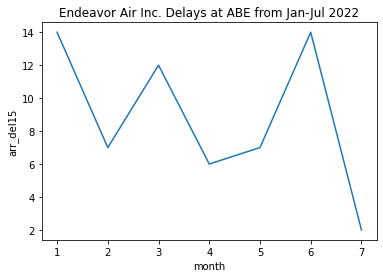

In [345]:
seaborn.lineplot(data=Endeavor_ABE_22_df, x="month", y="arr_del15").set(title='Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')

### Insights:
- There is major fluctuation in delays over a period this short for the given airline and airport
    - The number of delays is fairly low for this airport
- The number of delayed flights may not be an effective metric given the differences in sizes across airports. We will likely use the percentage of total fights delayed when comparing/analyzing data from more than one airport.

## Visualization 3: Delta Airline Delays at LAX by month

To better understand flight delay trends from 2020-2022, we plotted the total # of delays on Delta Airlines at the Los Angeles Airport (LAX) over the past 2 years. 

In [346]:
%sql Delta_LAX_Jan_df << SELECT * FROM df_delays WHERE carrier = 'DL' AND airport = 'LAX'
Delta_LAX_Jan_df.head()

dates = Delta_LAX_Jan_df[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
Delta_LAX_Jan_df['year_month'] = month_date

Delta_LAX_Jan_df.head()

Returning data to local variable Delta_LAX_Jan_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled,year_month
0,2022,7,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2934.0,488.0,221.01,12.42,...,38128.0,20967.0,842.0,3984.0,0.0,12335.0,CA,0.166326,0.008862,2022.583333
1,2022,6,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2855.0,604.0,302.15,16.86,...,39156.0,22502.0,1213.0,5618.0,55.0,9768.0,CA,0.211559,0.036427,2022.500000
2,2022,5,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2582.0,462.0,214.30,11.48,...,29272.0,15948.0,1044.0,5573.0,0.0,6707.0,CA,0.178931,0.030596,2022.416667
3,2022,4,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2394.0,477.0,193.98,8.25,...,30748.0,15994.0,1142.0,6193.0,51.0,7368.0,CA,0.199248,0.005848,2022.333333
4,2022,3,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2440.0,432.0,162.50,13.55,...,28342.0,12323.0,1432.0,6798.0,0.0,7789.0,CA,0.177049,0.004918,2022.250000


### Insights 

- Shown in the graph below, there seems to be a general increase in the number of delayed flights over time. 

- In both the previous graph of Endeavor Airlines, and in the graph below, it's important to note that despite an overall increase in delays, there is significant fluctuation in delays month-month. 
- Delta at LAX has a lot more delays than Endeavor Air at ABE
    - This reinforces that we should use percent of total flights delayed instead of counts due to variation between airports


(array([2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

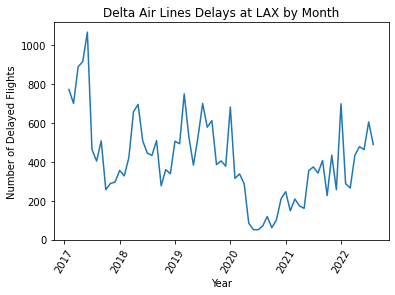

In [347]:
seaborn.lineplot(data=Delta_LAX_Jan_df, x="year_month", y="arr_del15").set(title='Delta Air Lines Delays at LAX by Month')
plt.xlabel('Year')
plt.ylabel('Number of Delayed Flights')
plt.xticks(rotation=60)

## Visualization 4: Delays by Airline at JFK for July 2022

To compare records by airlines, we created a barplot of the number of delays each airline had in July 2022 at JFK.

We first wanted to compare airlines at one airport to eliminate any other factors differing across all U.S airports. 

In [348]:
%sql JFK_Jul_2022_df << SELECT * FROM df_delays WHERE airport = 'JFK' AND year = 2022 AND month = 7
JFK_Jul_2022_df.head()

Returning data to local variable JFK_Jul_2022_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled
0,2022,7,9E,Endeavor Air Inc.,JFK,"New York, NY: John F. Kennedy International",2056.0,339.0,101.78,9.83,...,8.0,31737.0,11239.0,672.0,10642.0,0.0,9184.0,NY,0.164883,0.079767
1,2022,7,AA,American Airlines Inc.,JFK,"New York, NY: John F. Kennedy International",1385.0,366.0,124.81,14.06,...,5.0,25924.0,10864.0,1151.0,5783.0,37.0,8089.0,NY,0.264260,0.036823
2,2022,7,AS,Alaska Airlines Inc.,JFK,"New York, NY: John F. Kennedy International",372.0,58.0,17.69,0.00,...,2.0,2399.0,705.0,0.0,1011.0,13.0,670.0,NY,0.155914,0.000000
3,2022,7,B6,JetBlue Airways,JFK,"New York, NY: John F. Kennedy International",4064.0,1349.0,442.29,31.36,...,15.0,114603.0,40584.0,3240.0,20408.0,184.0,50187.0,NY,0.331939,0.023622
4,2022,7,DL,Delta Air Lines Inc.,JFK,"New York, NY: John F. Kennedy International",2318.0,515.0,172.85,10.08,...,10.0,41027.0,21033.0,621.0,8859.0,76.0,10438.0,NY,0.222174,0.021570


### Insights 

- Shown in the graph below, it is clear that delays vary depending on the airline carrier. 

- Jetblue has significantly more delasys in July 2022 at JFK than the other airlines that month. 

- Because this graph compares airlines over the same time frame, weather conditions are the same across this measure. 

- Therefore, this graph suggests that each airline was impacted differently by COVID-19.


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Endeavor Air Inc.'),
  Text(1, 0, 'American Airlines Inc.'),
  Text(2, 0, 'Alaska Airlines Inc.'),
  Text(3, 0, 'JetBlue Airways'),
  Text(4, 0, 'Delta Air Lines Inc.'),
  Text(5, 0, 'Hawaiian Airlines Inc.'),
  Text(6, 0, 'United Air Lines Inc.'),
  Text(7, 0, 'Republic Airline')])

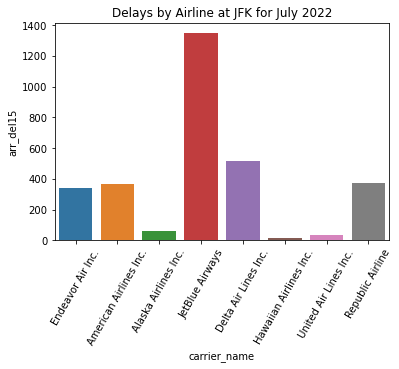

In [349]:
seaborn.barplot(data=JFK_Jul_2022_df, x="carrier_name", y="arr_del15").set(title='Delays by Airline at JFK for July 2022')
plt.xticks(rotation=60)

## Visualization 5: Number of Delays in 2020

Here, we experiment with regression plots to visualize how the number of delays vary over each month in 2020.

We chose to explore months over the year 2020 to analyze the number of delays before and throughout COVID-19.

In [350]:
%sql year20_df << SELECT * FROM df_delays WHERE year = 2020
year20_df.head()

Returning data to local variable year20_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled
0,2020,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",44.0,3.0,1.63,0.0,...,1.0,89.0,56.0,0.0,3.0,0.0,30.0,PA,0.068182,0.000000
1,2020,12,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",90.0,1.0,0.96,0.0,...,0.0,23.0,22.0,0.0,1.0,0.0,0.0,GA,0.011111,0.000000
2,2020,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",88.0,8.0,5.75,0.0,...,1.0,338.0,265.0,0.0,45.0,0.0,28.0,LA,0.090909,0.000000
3,2020,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",184.0,9.0,4.17,0.0,...,0.0,508.0,192.0,0.0,92.0,0.0,224.0,GA,0.048913,0.000000
4,2020,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",76.0,11.0,4.78,0.0,...,0.0,692.0,398.0,0.0,178.0,0.0,116.0,NY,0.144737,0.013158


Text(0.5, 1.0, 'Number of Delays in 2020')

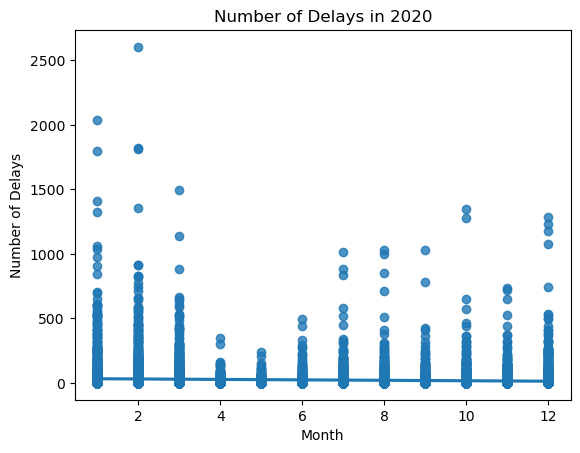

In [23]:
# scatterplot for x1 and y1
seaborn.regplot(data = year20_df, x='month', y='arr_del15')
plt.xlabel("Month")
plt.ylabel("Number of Delays")
plt.title("Number of Delays in 2020")

### Insights 

We wanted to explore different kinds of plots and regressions to run on this data after experimenting with this plot.
- The decreasing number of delays in month 3 (March 2020) and month 4 (April 2020) aligns with the spike in COVID cases that year.
- Otherwise, we do not see many clear patterns across delays over time due to the dataset’s organization over different U.S airports
- To create a more clear visualization, we will use the SQL GROUP BY function to aggregate the number of delays across all airports. 
- We want to add future insight by comparing the number of delays with the number of flights each month.
    - This would highlight the descrease in flights overall due to the COVID-19 outbreak, decreasing delays.
- To build off of this initial exploration, we want to compare the number of delays over 2020 with the number of COVID cases over 2020.


In [351]:
ny_data_find = pd.Series(df_covid_flight['state'] == 'NY')
    
ny_data = df_covid_flight.loc[ny_data_find]

ny_data.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled,tot_case,new_case,year_month
5,2022,7,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",114.0,16.0,3.70,1.82,...,207.0,64.0,0.0,743.0,NY,0.140351,0.043860,3089144,6609,2022.583333
11,2022,7,9E,Endeavor Air Inc.,BGM,"Binghamton, NY: Greater Binghamton/Edwin A. Li...",31.0,6.0,2.47,0.00,...,0.0,51.0,0.0,18.0,NY,0.193548,0.000000,3089144,6609,2022.583333
19,2022,7,9E,Endeavor Air Inc.,BUF,"Buffalo, NY: Buffalo Niagara International",177.0,24.0,8.62,1.40,...,105.0,345.0,0.0,225.0,NY,0.135593,0.079096,3089144,6609,2022.583333
49,2022,7,9E,Endeavor Air Inc.,HPN,"White Plains, NY: Westchester County",50.0,8.0,4.18,0.90,...,206.0,96.0,0.0,16.0,NY,0.160000,0.020000,3089144,6609,2022.583333
53,2022,7,9E,Endeavor Air Inc.,ITH,"Ithaca/Cortland, NY: Ithaca Tompkins Regional",10.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,NY,0.000000,0.000000,3089144,6609,2022.583333


In [25]:
%sql df_ny_covid_flight << SELECT MAX(tot_case) as tot_cases, year_month, MAX(new_case) as new_cases, SUM(arr_del15) as delayed_flights FROM ny_data GROUP BY year_month

df_ny_covid_flight.head()

Returning data to local variable df_ny_covid_flight


,tot_cases,year_month,new_cases,delayed_flights
0,3089144,2022.583333,6609,8040.0
1,3002193,2022.500000,4304,8257.0
2,2931132,2022.416667,13472,8108.0
3,2779790,2022.333333,6434,7709.0
4,2671212,2022.250000,2570,7839.0


## Visualization 6: Delayed Flights vs. New COVID Cases for New York

This visualization of Delayed Flights vs. New COVID Cases for New York shows us that there is not a strong relationship between the number of delaydfed flights and the number of new covid cases at first glance. We will have to do some further data exploration to try to understand why.

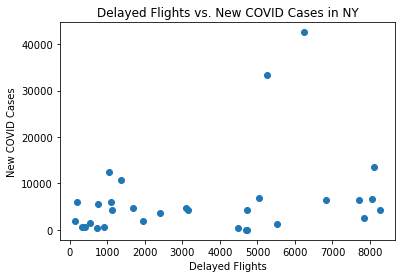

In [352]:
ny_x = df_ny_covid_flight['delayed_flights']
ny_y = df_ny_covid_flight['new_cases']

plt.scatter(ny_x, ny_y)
plt.xlabel("Delayed Flights")
plt.ylabel("New COVID Cases")
plt.title("Delayed Flights vs. New COVID Cases in NY")
plt.show()

### Filtering Datasets

In order to study delayed flights and covid cases over time, new cases and total cases must be combined for each month of each year.

In [353]:
%sql df_all_covid_flight << SELECT year_month, MAX(new_case) as new_case, MAX(tot_case) as tot_case, MAX(arr_del15) as delayed_flights FROM df_covid_flight GROUP BY year_month
df_all_covid_flight.head()

Returning data to local variable df_all_covid_flight


,year_month,new_case,tot_case,delayed_flights
0,2022.583333,79204,10688199,3479.0
1,2022.500000,69623,10076018,3137.0
2,2022.416667,59488,9602503,2573.0
3,2022.333333,22289,9221030,2502.0
4,2022.250000,15349,9091230,2713.0


## Visualization 7: Covid Cases vs. Airline Delays

The following visualization explore the relationship between all covid cases, new covid cases, and airline flight delays over time. We also created a correlation matrix to look at the correlations between covid cases and different types of delays.

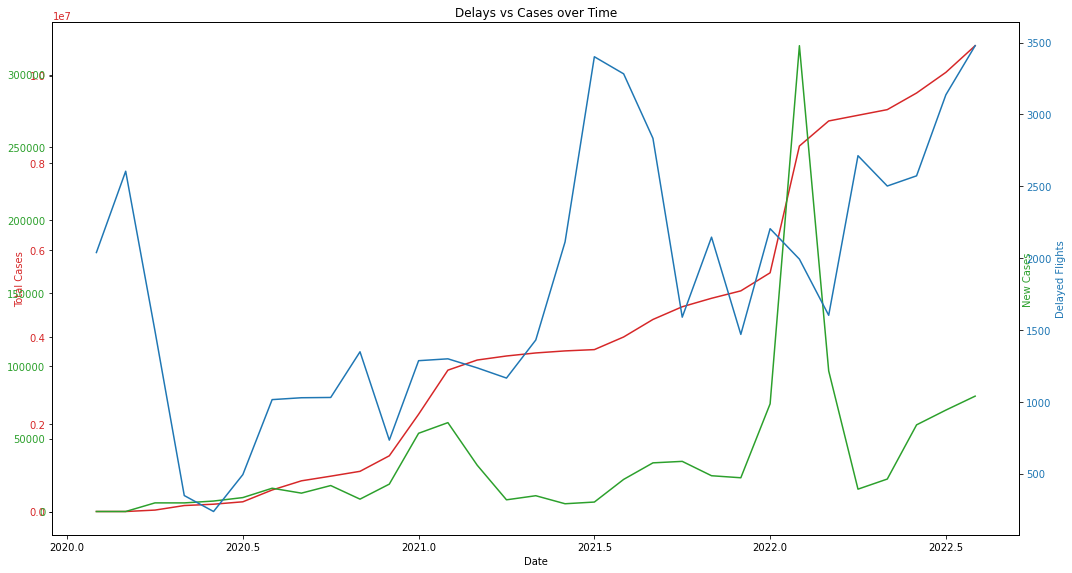

In [354]:
fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color=color)
ax1.plot(df_all_covid_flight.year_month, df_all_covid_flight.tot_case, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:green'
ax2.set_ylabel('New Cases', color=color)
ax2.plot(df_all_covid_flight.year_month, df_all_covid_flight.new_case, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax2.twinx()

color = 'tab:blue'
ax3.set_ylabel('Delayed Flights', color=color)
ax3.plot(df_all_covid_flight.year_month, df_all_covid_flight.delayed_flights, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Delays vs Cases over Time')
plt.show()

### Interpretation of Visualization 7

We see here that all three y inputs (total cases, new cases, and delayed flights) have positive growth. Total cases looks more linear because it is cumulative. New cases and flight delays, however, have clear dramatic peaks and valleys. This is interesting and we would like to explore this further. We wonder if there is a specific type of delay that has the greatest impact. Below is a correlation matrix that allows us to look further into the different types of delays followed by a correlation matrix for total delayed flights.

In [355]:
df_covid_delays = df_covid_flight.iloc[:, 2:]

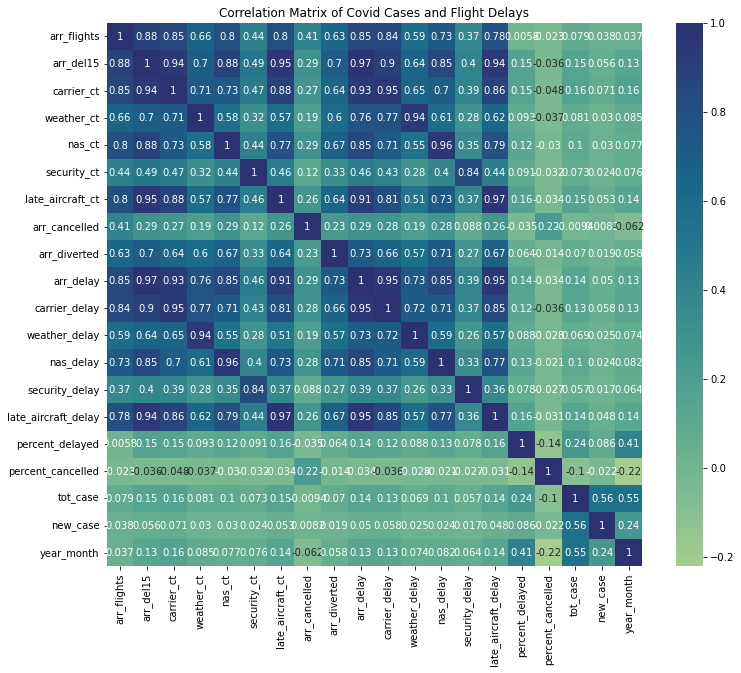

In [356]:
fig, ax = plt.subplots(figsize=(12,10))

corr = df_covid_delays.corr()
seaborn.heatmap(corr, cmap='crest', xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax=ax)
plt.title('Correlation Matrix of Covid Cases and Flight Delays')
plt.show()

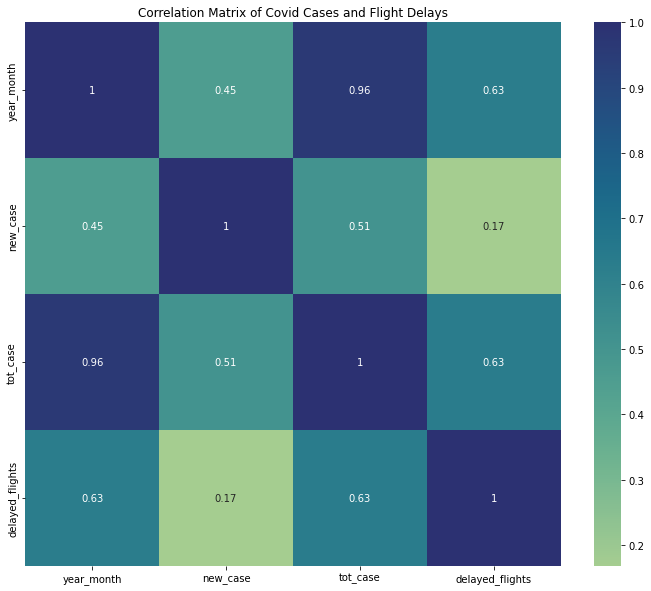

In [357]:
fig, ax = plt.subplots(figsize=(12,10))

corr = df_all_covid_flight.corr()
seaborn.heatmap(corr, cmap='crest', xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax=ax)
plt.title('Correlation Matrix of Covid Cases and Flight Delays')
plt.show()

### Interpretation of Correlation Matrices

We see very high correlation between different flight delay types. This makes sense given the patterns we saw in earlier visualizations. However, we see lower correlations between cases and different flight delays. So, we made a new correlation matrix for all delayed flights and covid cases. In the second correlation matrix, we find a much higher correlation between total number of cases and delayed flights. We can run a linear regression to understand this relationship better.

## Multiple Linear Regression 1 ## 
**Covid Cases to Predict Delayed Flights**

We will run a multiple linear regression of delayed flights to predict covid cases and also do this by state for the states with the most and least amounts of covid.

#### Independent Variables ####
- Total covid cases in the U.S. and by state
- Time

#### Dependent Variable ####
- Total delayed flights and by state

In [358]:
df_covid_flight['delayed_flights'] = df_covid_flight['arr_del15']

def mutliple_regression(df):
    model = LinearRegression()
    
 
    # independent variables: time and covid rate
    X = df[['year_month', 'tot_case']].fillna(0).tot_case.values.reshape(-1,1)
    Y = df['delayed_flights'].fillna(0)
    SEED = 41
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = SEED)

    model.fit(X_train, y_train)
    
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)

    print('R2 score is: ', model.score(X, Y))
    print('intercept: ', model.intercept_)
    print('slope: ', model.coef_)
    print('Model Train score: ', train_score)
    print('Model Test score: ', test_score)
    print("MAE: ", mae)
    print("MSE: ", mse)
#     print("RSME: ", rsme)

### Delays Predicted by Total Covid Cases in All States 

In [359]:
mutliple_regression(df_all_covid_flight)

R2 score is:  0.39693322127256525
intercept:  1204.2732267659098
slope:  [0.00016749]
Model Train score:  0.4375316760130147
Model Test score:  0.04849059752805562
MAE:  792.2749657203069
MSE:  667926.0841020668


## Evaluation of Multiple Linear Regression 1 Results

**R2 value**: 

For all states combined,~ 39.69% of the variation in the response variable (total delayed flights) can be explained by the two predictor variables (total covid cases and time) in the model.

**Intercept and Slope**

The intercept of ~1204.273  tells us that when all independent variables are equal to zero, the predicted value of total delayed flights is 1204. However, this is not likely to happen. The slope of 0.000167 indicates that for every one unit increase in total covid cases in the US, there is an increase of 0.000167 in total delayed flights. 

**Model Train/Test Score:** How much of the data is explained by our model

The model train score of 0.4375 tells us that the model is able to correctly predict ~43.75% of the variation in the data it is being trained on. The model test score of 0.0485 tells us that the model is able to correctly predict 4.85% of the variation in the data it is being tested on.

**MAE:** 

The MAE of 792.275 indicates that the model is off by an average of 792.275 when predicting total delayed flights given total flights delayed at a given time.

**MSE:** 
The MSE of indicates that the average deviation of the predicted delayed flights from the actual delayed flights is 667926.

## Carrier Delays and Covid Cases Over Time

Given the press around airline delays due to staff shortages, we want to study the relationship between carrier_ct and covid cases over time. 

### Filtering Datasets

In order to study carrier_ct and covid cases over time, new cases and total cases must be combined for each month of each year.

In [360]:
%sql df_carrier_delay_by_state << SELECT state, year, year_month, SUM(carrier_ct) AS carrier_ct, MAX(new_case) AS new_case, MAX(tot_case) AS tot_case FROM df_covid_flight GROUP BY state, year, year_month ORDER BY state ASC
df_carrier_delay_by_state.head()

Returning data to local variable df_carrier_delay_by_state


,state,year,year_month,carrier_ct,new_case,tot_case
0,AK,2022,2022.583333,305.28,2462,271101
1,AK,2022,2022.500000,278.81,2597,261987
2,AK,2022,2022.416667,245.86,1903,251425
3,AK,2021,2022.000000,322.18,940,151583
4,AK,2021,2021.916667,186.23,1522,145581


In [361]:
%sql df_carrier_delay_by_month << SELECT MAX(state) as state, sum(carrier_ct) as carrier_ct, sum(new_case) as new_case, year_month FROM df_covid_flight GROUP BY year_month
df_carrier_delay_by_month.head()

Returning data to local variable df_carrier_delay_by_month


,state,carrier_ct,new_case,year_month
0,WY,50210.51,24294291,2022.583333
1,WY,52329.73,21992128,2022.500000
2,WY,45183.10,20125050,2022.416667
3,WY,45034.10,8455674,2022.333333
4,WY,43572.87,5664146,2022.250000


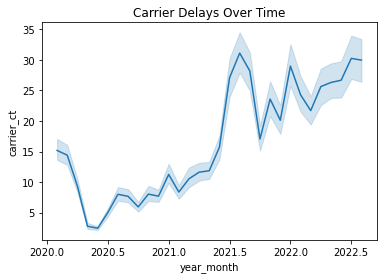

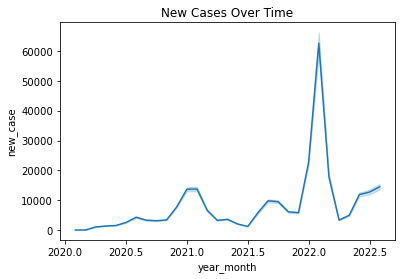

In [362]:
seaborn.lineplot(data=df_covid_flight, x='year_month', y='carrier_ct')
plt.title('Carrier Delays Over Time')
plt.show()

seaborn.lineplot(data=df_covid_flight, x='year_month', y='new_case')
plt.title('New Cases Over Time')
plt.show()

### Sort by Carriers and States

Now we want to look to see if there are any outstanding outliers across states and airline carriers when it comes to covid cases and carrier delays.

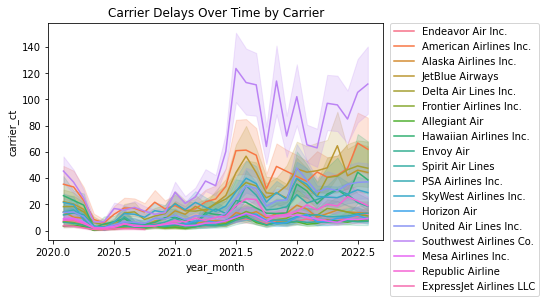

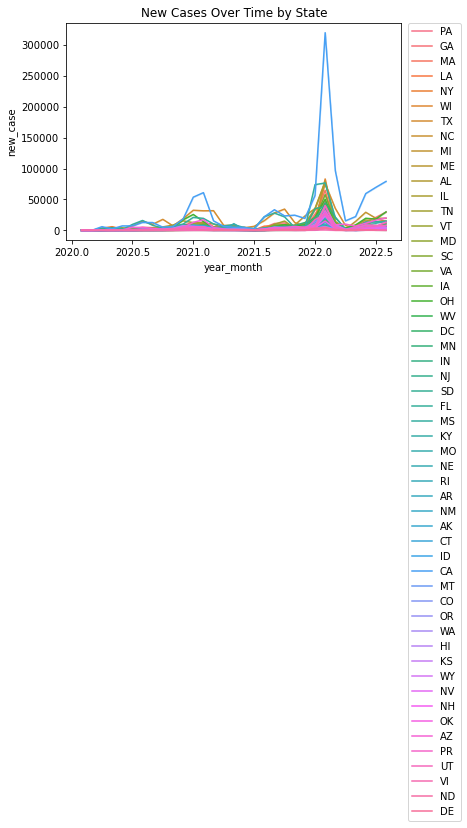

In [363]:
seaborn.lineplot(data=df_covid_flight, x='year_month', y='carrier_ct', hue = 'carrier_name')
plt.title('Carrier Delays Over Time by Carrier')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

seaborn.lineplot(data=df_covid_flight, x='year_month', y='new_case', hue = 'state')
plt.title('New Cases Over Time by State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

### Interpretation of Visualizations Above

We can see that Southwest has a much higher number of carrier delays. We know that Southwest's main hub is Denver, CO and the second-largest hub is Las Vegas, NV. However, we do not see anything out of the ordinary for the covid cases in CO and NV. 

### Carrier Delays and Covid Cases Over Time Combined

To look more closely at the relationship between covid cases and carrier delays over time, we can combine the two into one graph to see if it is different from Visualization 7.

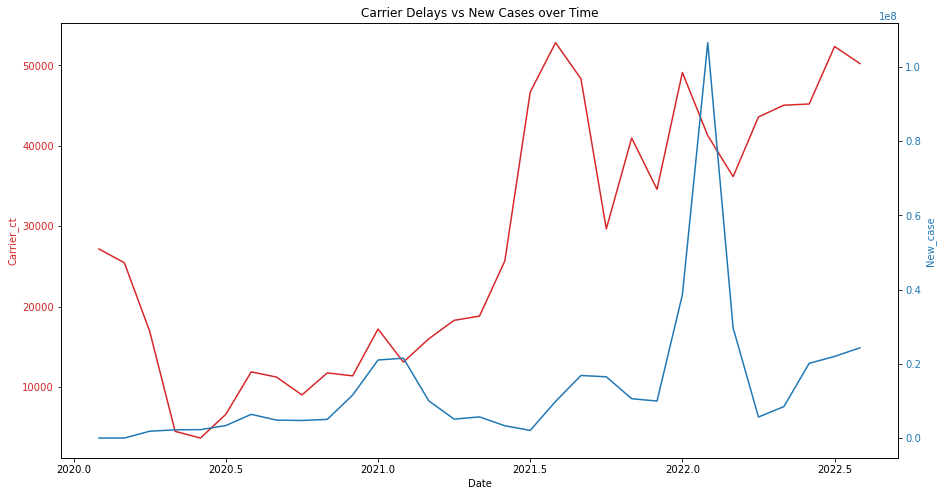

In [364]:
fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Carrier_ct', color=color)
ax1.plot(df_carrier_delay_by_month.year_month, df_carrier_delay_by_month.carrier_ct, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('New_case', color=color)
ax2.plot(df_carrier_delay_by_month.year_month, df_carrier_delay_by_month.new_case, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Carrier Delays vs New Cases over Time')
plt.show()

### Correlation Matrix Between Carrier Delays and Covid Cases by State

In order to attempt to identify correlation between carrier delays and covid cases, we created a correlation matrix using the carrier delay by state dataframe.

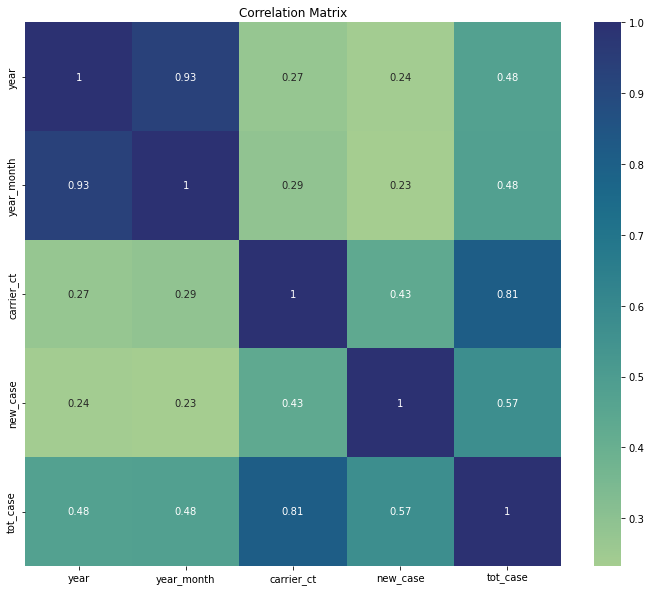

In [365]:
fig, ax = plt.subplots(figsize=(12,10))

corr = df_carrier_delay_by_state.corr()
seaborn.heatmap(corr, cmap='crest', xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax=ax)
plt.title('Correlation Matrix')
plt.show()

### Interpretation of Visualization Above

We see similar a pattern in the graph to that of Visualization 7. As a result, we can hypothesize that covid cases and carrier delays do not have a special relationship apart from other types of delays and the total number of delays. To verify, we can run a linear regression.

Before running the regression, in order to detect a potential multicollinearity problem, we created a correlation matrix and visually check whether any of the variables are highly correlated with each other. Since year_month and year are highly correlated, we will run the regression by omitting year. Below is the new dataframe and correlation matrix with year_month as the only measure of time.

In [366]:
%sql df_carrier_delay_by_state_no_year << SELECT state, year_month, sum(carrier_ct) AS carrier_ct, sum(new_case) AS new_case FROM df_covid_flight GROUP BY state, year_month ORDER BY state ASC
df_carrier_delay_by_state_no_year.head()

Returning data to local variable df_carrier_delay_by_state_no_year


,state,year_month,carrier_ct,new_case
0,AK,2022.583333,305.28,76322
1,AK,2022.500000,278.81,77910
2,AK,2022.416667,245.86,51381
3,AK,2022.333333,169.44,34661
4,AK,2022.250000,162.40,18699


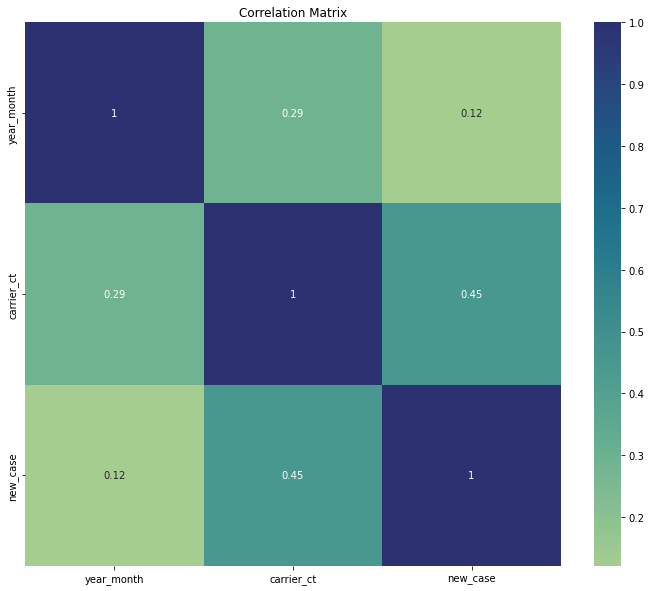

In [367]:
fig, ax = plt.subplots(figsize=(12,10))

corr = df_carrier_delay_by_state_no_year.corr()
seaborn.heatmap(corr, cmap='crest', xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax=ax)
plt.title('Correlation Matrix')
plt.show()

## Multiple Linear Regression 2 ##
**Covid Cases to Predict Air Carrier Delays**

Now we will look at multiple linear regressio for all covid cases within a state and all carrier delays separated by state.

#### Independent Variables ####
- time
- new covid in that state

#### Dependent Variable ####
- carrier delays for all of the airlines in that state

In [370]:
def mutliple_regression_carrier_ct(df):
    model = LinearRegression()

    # independent variables: time and covid rate
    X = df[["year_month","new_case"]]
    Y = df["carrier_ct"].fillna(0)
    SEED = 41
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = SEED)

    model.fit(X_train, y_train)
    
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print('R2 score is: ', model.score(X, Y))
    print('intercept: ', model.intercept_)
    print('slope: ', model.coef_)
    print('Model Train score: ', train_score)
    print('Model Test score: ', test_score)
    print("MAE: ", mae)
    print("MSE: ", mse)

### Carrier Delays Predicted by New Covid Cases in All States 

In [369]:
mutliple_regression_carrier_ct(df_carrier_delay_by_state_no_year)

R2 score is:  0.25936634527512337
intercept:  -585507.408916355
slope:  [2.89901695e+02 2.46477509e-04]
Model Train score:  0.26243424386114456
Model Test score:  0.20010844459073152
MAE:  369.7948242474971
MSE:  308676.6241048473


## Evaluation of Multiple Linear Regression 2 Results

**R2 value**: 

The R2 score of this model is 0.259, which indicates that around 25.9% of the variance in the dependent variable (carrier flight delays) can be explained by the independent variables (time and covid cases).

**Intercept and Slope**

The intercept of the model is -585507.41, and the slope of the model is [2.899017e+02, 2.464775e-04], which indicates that for every unit increase in time, carrier flight delays increase by 289.90 and for every unit increase in covid cases, carrier flight delays increase by 0.00024648.

**Model Train/Test Score:** How much of the data is explained by our model

The model train score is 0.262 and the model test score is 0.200, which indicates that the model is performing slightly better on the data it was trained on than on unseen data.

**MAE:** 

The mean absolute error of the model is 369.79, which indicates that on average, the model is 369.79 units off in predicting the carrier flight delays.

**MSE:** 

The mean squared error of the model is 308676.62, which indicates that, on average, the model is predicting the carrier flight delays with an error of 308676.62 units squared.


## Multiple Linear Regression 3 ##
**Covid Cases to Predict Air Carrier Delays in Each State with Most and Least Covid**

Now we will look at multiple linear regressio for all covid cases within a state and all carrier delays separated by state.

#### Independent Variables ####
- time
- new covid in that state

#### Dependent Variable ####
- carrier delays for all of the airlines in that state

### Carrier Delays Predicted by New Covid Cases in States with Most and Least Covid

In [327]:
### Carrier Delays Predicted by New Covid Cases in All States # find states with most and least covid
average_covid_df = df_covid_flight[['state', 'new_case']].groupby(['state']).mean(['new_case']).sort_values(by='new_case', ascending=False)
average_covid_df = average_covid_df.reset_index()

most_covid = average_covid_df.head(4)['state'].tolist()
print(most_covid)

least_covid = average_covid_df.tail(4)['state'].tolist()
print(least_covid)

['CA', 'TX', 'FL', 'MI']
['VT', 'WY', 'ME', 'VI']


In [328]:
# run multiple_regression for states with most covid
for state in most_covid:
    state_true = pd.Series(df_covid_flight['state'] == state)
    state_df = df_covid_flight.loc[state_true]

    print("Multiple Regression for: ", state)
    mutliple_regression_carrier_ct(state_df)
    print('\n')

Multiple Regression for:  CA
R2 score is:  0.0405698369856351
intercept:  -27334.78480542854
slope:  [ 1.35345205e+01 -2.41367755e-05]
Model Train score:  0.03705186810222105
Model Test score:  0.052112137595433095
MAE:  27.754007807847014
MSE:  2395.2489540871334


Multiple Regression for:  TX
R2 score is:  0.022067511516552285
intercept:  -31554.693081226633
slope:  [ 1.5623991e+01 -1.2025075e-04]
Model Train score:  0.02557903273416895
Model Test score:  0.00728892841399964
MAE:  31.057380414436977
MSE:  4727.960134674162


Multiple Regression for:  FL
R2 score is:  0.059498966968757006
intercept:  -27731.792323261878
slope:  [1.37301773e+01 4.85528179e-05]
Model Train score:  0.05536662609641463
Model Test score:  0.0828294525519998
MAE:  22.946852081331365
MSE:  1276.2365144290302


Multiple Regression for:  MI
R2 score is:  0.020755081296896072
intercept:  -12404.168884059178
slope:  [6.14307983e+00 1.09875528e-04]
Model Train score:  0.0215499671562962
Model Test score:  0.01797

In [329]:
# run multiple_regression for states with least covid
for state in least_covid:
    state_true = pd.Series(df_covid_flight['state'] == state)
    state_df = df_covid_flight.loc[state_true]

    print("Multiple Regression for: ", state)
    mutliple_regression_carrier_ct(state_df)
    print('\n')

Multiple Regression for:  VT
R2 score is:  0.2225966412027759
intercept:  -4869.890525060713
slope:  [2.41100116e+00 2.28964030e-05]
Model Train score:  0.21982621190326812
Model Test score:  0.22060000146758096
MAE:  3.567286446796914
MSE:  21.11653989094002


Multiple Regression for:  WY
R2 score is:  0.1024254665357216
intercept:  -4984.484390429785
slope:  [2.46898052e+00 3.88811422e-04]
Model Train score:  0.09219155318795558
Model Test score:  0.14136890537589786
MAE:  4.3474674996171645
MSE:  39.48325403652411


Multiple Regression for:  ME
R2 score is:  0.1694957678669211
intercept:  -7630.8785311380425
slope:  [ 3.77769322e+00 -1.00940508e-03]
Model Train score:  0.1750317276063632
Model Test score:  0.1309661538210355
MAE:  3.4877109008172527
MSE:  20.260167415658028


Multiple Regression for:  VI
R2 score is:  0.12195963473244065
intercept:  -3518.844682844991
slope:  [1.74289389 0.00187493]
Model Train score:  0.10782164525784332
Model Test score:  0.13904099320407104
MAE: 

## Evaluation of Multiple Linear Regression 3 Results

**R2 values**: 
The 4 states with the **most** COVID cases were CA, TX, FL, and IL. Listed in this same order, these 4 states had R2 scores of ~0.0405, 0.022, 0.059, and 0.0208. On the other hand, the 4 states with the **least** COVID cases were WY, DC, VT, and VI. Listed in this same order, these 4 states had R2 scores of ~0.222, 0.102, 0.169, and 0.122. 
**Model Train/Test Score:** How much of the data is explained by our model
- We had really low train and test scores which is means our model is not a good representation of our training data or our testing data
- Train and test scores were close in value for each regression which means that our model was equally ineffective for training data and testing data
- Train scores ranged from 0.020 - 0.059 for states with the **most COVID cases**.
- Train scores ranged from 0.102 - 0.222 for states with the **least COVID cases**
- Test scores ranged from 0.037 to 0.08 for states with the **most COVID cases**.
- Test scores ranged from 0.130 to 0.246 for states with the **least COVID cases**.
- Our model fit our training data better for states with less COVID cases
- Our model fit our testing data better for states with less COVID cases
 
**MAE:** 
- For the states with the **least COVID cases**, MAE values ranged from ~3.48 to ~4.34
- For states with the **most COVID cases**, MAE values ranged from ~15.739 to ~30.546
 
 
**MSE:** 
- For the states with the **least COVID cases**, MSE values ranged from ~20.2 - 39.48
- For states with the **most COVID cases**, MSE values ranged from ~1276.23- 4440.908


## Interpretation of Results ###

### Multiple Linear Regression 1 ###
We ran a multiple linear regression model for all covid cases and flight delays. 
Our significance values indicate that the model is relatively successful in predicting the delayed flights based on the independent variables of total covid cases in the U.S. by state and time. The  R2 score of 0.396 suggests that the two variables are correlated and that the model is able to capture the relationship between the two variables. 
The relatively high model train score of 0.4375  indicates that the model is able to accurately capture the relationship between the independent variables and the dependent variables for 43.75% of the data. The relatively low model test score of 0.048 suggests that the model can only predict around 4.8% of data correctly. This could be due to the fact that the data is limited and does not have enough information to accurately predict the delayed flights. The high MAE and MSE scores of ~792 and 667926, respectively, suggest that the model is making significant errors in its predictions. 
Ultimately, this model is able to capture the overall relationship between the independent and dependent variables.
 
### Multiple Linear Regression 2 ###

We ran a multiple linear regression model for all covid cases and carrier delays.

There likely are other factors that are influencing delayed flights that are not being taken into account in the model. This is likely because the model is only taking into account total covid cases in the US by state and time, and is not taking into account other factors such as the weather, airport infrastructure, or airline policies. The model performs better on the training data than on the test data, which indicates that the model is overfit to the training data and does not generalize well to new data. This is likely due to the small size of the dataset, or the lack of other variables being taken into account in the model. The MAE and MSE indicate the average amount of error in the model’s prediction of delayed flights, which could be due to the factors mentioned above.

### Multiple Linear Regression 3 ###

We also ran one for carrier_ct in states with the most and least covid in the United States. We wanted to predict how a state's new number of covid cases and the time can predict the number of delays. For the 8 states we ran the model on, the highest R2 score we got was 0.22. This is not a significant result, which tells us that time and number of new cases do not have a statistically significant impact on the number of airline delays.
 
One interesting factor is the difference in R2, MAE, MSE, and model scores between states with the highest number of COVID cases and states with the lowest number of cases. 

The R2 scores for the 4 states with **less** COVID cases are multiple times greater than for the 4 states with the **most** COVID cases. This means that we could more accurately predict flight delays based for the 4 states with the LEAST # of COVID cases than for the 4 states with the greatest # of COVID cases. 

Additionally, model scores for test and train data for states with **less COVID** cases were ranged higher than model scores with **greater COVID numbers*. This confirms that our model is generally better at predicting flight delays for the states with lower COVID numbers.

For 3 out of 4 states in each COVID group, the model training score was slightly lower than the model test score- although the greatest difference betweens scores was 0.05 (this difference occurred in Wyoming). It is not good that the majority of test scores were higher than train scores and this implies that the model likely overfit our training data. Overfitting could be due to duplicate data in our DataFrame or the dataset may simply be too small to accurately train the model. To attempt to avoid overfitting in future research, cross validation could be performed on this dataset. 

Similar to model scores and R2 scores, MAE and MSE scores were **lower** for the states with **less** COVID cases than they were for states with **higher** COVID numbers. This indicates that flight delay predictions (from testing data) were closer to the true  # of delays for states with less COVID overall. 

Our **R2** results mean that our regression model performed better for the 4 states with the **lowest number of COVID cases** than the 4 states with the highest number of COVID cases. The difference in **model scores** tell us that this model was more representative of the data for the 4 states with the least # of COVID cases than for the 4 states with greater COVID rates. The lower error scores (MAE and MSE) tell us that the predicted values were closer to the actual values for the 4 states with the **least amount of COVID cases**. 

Our R2, test/train model scores, and MAE/MSE statistics were better for the 4 states with **less COVID cases**



# Conclusions

From our analysis of our datasets and multiple linear regression models, we can conclude that there is a correlation between covid cases and flight delays in the United States from January 2022-July 2022 since we are able to capture the relationship through Regression 1. However, given the chaotic nature of the COVID-19 pandemic and other reasons for flight delays, we cannot say for certain how much influence covid had on delays. We also cannot conclude anything about other factors such as weather, policy, logistics, economics, etc. 

Although we noticed similar positive growth and fluctuations between delayed flights and new covid cases, as well as carrier delays and new covid cases, we could not identify clear differences between airlines, states, and delay types. We hypothesize that the samples we analyzed were too small to find any correlation. However, when we looked at the data for all states combined, we found higher R2 scores.

Due to the unexpected and immense challenges faced by the airline industry as a result of the recent pandemic, it's possible that flight data is too highly variable to make accurate predictions using ML models. Our model was ultimately not accurate nor representative of the data for the 8 states we tested. 

It is worth noting that **for the 8 states we tested, higher COVID rates correlated with worse flight delay predictions.** Although the the model was not particularly effective for any states we chose, the statistics summarized above show that our model was **more accurate and more representative** of the data for WY, DC, VT, and VI: the 4 states with the **least COVID cases**.

Although flight delays and COVID cases have increased similarly over time, we conclude that it is not possible to predict flight delays given the current data set accurately. In addition, we found that flight delay predictions for the 4 states with the lowest number of COVID cases were far more accurate than the predictions for the 4 states with the highest number of COVID cases.

From our analysis for Regression 3 (relative to our hypotheses and preregistration statements) and related data analysis, we did not find any meaningful correlation between covid cases and flight delays. However, we did find an interesting phenomenon in which states with the highest covid cases had much lower R2 scores than states with the lowest covid cases. 

One possible explanation for this phenomenon is that states with lower covid also have higher R2 scores (correlation to carrier flight delays) because they tend to be smaller states with fewer resources. For example, states with the least covid are ['VT', 'WY', 'ME', 'VI'], and states with the most covid are ['CA', 'TX', 'FL', 'MI']. An airport in Vermont or Wyoming is less likely to be able to accommodate a short staff or sick pilot (reasons for carrier_ct) than an airport in California or Texas. If there is no pilot in a place with a low population to begin with, it’s harder to find another pilot.

# Limitations #

In our study, we were not able to identify exactly which delays were caused by covid-related causes, which impacted the results of our study. While we were able to identify what delays were caused by carrier-related errors, not all of these delays were caused by covid issues, and could be caused by other logistical issues.

#### First Data Set (Flight Delays):

* The data is somewhat limited because it does not include all flight data for the specified time period. Although the US has 19,622 airports, the data only includes information about 384 airports. Another limitation is that the data does not cover delays experienced by flights operated by US-based airlines but originating or arriving at airports outside the US. Although we are looking at the relationship between COVID-19 cases and delays in the US, international statistics could potentially affect our data too.

#### Second Data Set (COVID-19 Cases):

* There are several limitations to any COVID-19 dataset. First, there is a lot of noise and misinformation surrounding the pandemic, making it difficult to separate fact from fiction. Secondly, different jurisdictions handle their data differently, making it difficult to get a complete picture of the pandemic within the United States. The data may also be affected by political and geographical demographics.

#### Limitations on Analysis:

* In our study, we were not able to identify exactly which delays were caused by covid-related causes, which impacted the results of our study. 
* While we were able to identify what delays were caused by carrier-related errors, not all of these delays were caused by covid issues, and could be caused by other logistical issues.
* Moreover, we recognize that our data is limited by time, reporting behavior, and population sample size differences, which could have impacted our results and analysis.

# Source Code #
https://github.com/maddiklancher/2950Project

# Acknowledgments #

We would like to acknowledge the documentation for the libraries we used to complete our data analysis, Stack Overflow, Geeks for Geeks, and other adjacent developer forums. Finally, we would like to thank our professors, TAs, and peers for all their support throughout the duration of this course and project

# Appendix #

## Data Cleaning:

**Airline Delays Dataset**

* The data was exported as a CSV file. We did not remove any columns so that we could analyze all the different types of delays as well as geographic and carrier information. We basically did our “cleaning” by filtering on the BTS website to find flight delay information from January 2017 - July 2022.

**COVID-19 Cases Dataset**

* The data was exported as a CSV file. We removed unnecessary columns and added a couple of new columns to make our analysis easier. In addition, we compressed certain rows based on state, month, and year to ensure that our data were consistent with the airline delay dataset. The initial dataset was organized by day. A lot of these edits were made so as to ensure it was a fully usable dataset, and as well to ensure that there were no values that were null or would affect our analysis work. More specifically, our cleaning focused on:

* Converting objects to DateTime: This was a significant step, because much of our analysis required us to pull dates from the datasets. Unfortunately, the dates were not formatted within the CSV as DateTime objects, and thus our job was simply to transform these dates into DateTime objects. This was done using the pandas to_datetime() function, and assisted the team immensely in being able to directly pull the dates/times in a usable form for our data analysis. By being able to have these dates in DateTime objects, we are then able to use them without issue (in comparison to strings or other types) within our data analysis. 

* Adding month and year columns: In order to join the datasets by state, we needed to create new columns for the year and month of each record. This was simple since we already converted dates into DateTime objects. By adding these two columns, we were able to sum the covid cases and group by state, year, and month. 

* Removing all attributes except year	, month, state, tot_case, and new_case: We made the conscious decision to only use year, month, state, total cases, and new cases. We decided to omit the rest because our research question only pertains to COVID-19 cases, and not deaths. Moreover, we are not concerned with probable cases as the data is subjective based on whether or not consent was given to include those metrics. As a result, we decided to stick only with objective data for our analysis.